Importing the needed libraries.

In [144]:
import glob
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Task 1. The function for concatenating data from different files into one pandas DataFrame. Function takes three arguments (str format only): 
- path_to_data_folder - path to folder with data files (example "/home/olympics")
- files_format - file format including the dot (example ".csv")
- separator - separator (example ";")

In [145]:
""" to read all tables of specific format from the precise folder and cocncatenate them into resulting table """
def tables_concatenation(path_to_data_folder, files_format, separator):
    result_table = pd.DataFrame()
    for file in glob.glob(f'{path_to_data_folder}/*{files_format}'):
        temp_table = pd.read_csv(file, sep=separator)
        result_table = pd.concat([result_table, temp_table])
    return result_table

olympic_data = tables_concatenation('../data', '.csv', ',')


Task 2. Check whether all data is correct and if not correct it.

First, let's have a look at the general information on the dataset.

In [146]:
olympic_data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,68370,Helmut Lehmann,M,25.0,178.0,77.0,Switzerland,SUI,1984 Summer,1984.0,Summer,Los Angeles,Canoeing,"Canoeing Men's Kayak Fours, 1,000 metres",NaN
1,68371,Jens Lehmann,M,24.0,188.0,82.0,Germany,GER,1992 Summer,1992.0,Summer,Barcelona,Cycling,"Cycling Men's Individual Pursuit, 4,000 metres",Silver
2,68371,Jens Lehmann,M,24.0,188.0,82.0,Germany,GER,1992 Summer,1992.0,Summer,Barcelona,Cycling,"Cycling Men's Team Pursuit, 4,000 metres",Gold
3,68371,Jens Lehmann,M,32.0,188.0,82.0,Germany,GER,2000 Summer,2000.0,Summer,Sydney,Cycling,"Cycling Men's Individual Pursuit, 4,000 metres",Silver
4,68371,Jens Lehmann,M,32.0,188.0,82.0,Germany,GER,2000 Summer,2000.0,Summer,Sydney,Cycling,"Cycling Men's Team Pursuit, 4,000 metres",Gold


In [147]:
olympic_data.shape

(271115, 15)

In [148]:
olympic_data.isna().sum() 

ID             0
Name           1
Sex            2
Age         9476
Height     60172
Weight     62876
Team           3
NOC            4
Games          5
Year           7
Season         7
City           7
Sport          7
Event          8
Medal     231333
dtype: int64

Let's see the column types. I have used for that .dtypes and .info() beacause .dtypes returns column types in a more appealing to me format but .info() returns more information.
At the first look, no numeric columns have object type, but perhaps some numeric columns of float64 format such as Age, Height, Weight, Year could be converted into int64. For that I will need to take a look at all unique values in the columns.

In [149]:
olympic_data.dtypes

ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year      float64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object

In [150]:
olympic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271115 entries, 0 to 22409
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271115 non-null  int64  
 1   Name    271114 non-null  object 
 2   Sex     271113 non-null  object 
 3   Age     261639 non-null  float64
 4   Height  210943 non-null  float64
 5   Weight  208239 non-null  float64
 6   Team    271112 non-null  object 
 7   NOC     271111 non-null  object 
 8   Games   271110 non-null  object 
 9   Year    271108 non-null  float64
 10  Season  271108 non-null  object 
 11  City    271108 non-null  object 
 12  Sport   271108 non-null  object 
 13  Event   271107 non-null  object 
 14  Medal   39782 non-null   object 
dtypes: float64(4), int64(1), object(10)
memory usage: 33.1+ MB


Now I want to see the basic statistics of raw data and see the lists of unique values for every column.

In [151]:
olympic_data.describe()

,ID,Age,Height,Weight,Year
count,271115.000000,261639.000000,210943.000000,208239.000000,271108.000000
mean,68248.828641,25.557669,175.339760,70.702232,1978.378314
std,39022.303374,6.407296,10.524619,14.348878,29.877579
min,1.000000,10.000000,127.000000,7.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.000000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,240.000000,340.000000,214.000000,2016.000000


In [152]:
for col in olympic_data:
    print(f"Feature {col} has {olympic_data[col].nunique()} unique values: {olympic_data[col].unique()}")

Feature ID has 135571 unique values: [ 68370  68371  68372 ... 113713 113714 113715]
Feature Name has 134732 unique values: ['Helmut Lehmann' 'Jens Lehmann' 'Karl-Heinz Lehmann' ... 'David Spears'
 'Marino Specia' 'Pietro Spec']
Feature Sex has 3 unique values: ['M' 'F' 'G' nan]
Feature Age has 75 unique values: [ 25.  24.  32.  23.  29.  21.  33.  37.  26.  22.  30.  20.  19.  28.
  15.  31.  nan  50.  16.  36.  27.  18.  17.  41.  38.  14.  56.  34.
  58.  62.  35.  39.  43.  53.  42.  54.  47.  40.  44.  52.  46.  13.
  55.  48.  60.  49.  57.  80.  72.  45.  11.  61.  51.  10.  65.  69.
  66.  12.  68.  71.  81.  59.  63.  64.  67.  96.  97.  70.  76.  77.
 240.  74.  88.  73.  75.  84.]
Feature Height has 96 unique values: [178. 188. 169. 172.  nan 166. 155. 173. 181. 198. 184. 170. 163. 176.
 179. 183. 165. 189. 158. 161. 194. 187. 185. 164. 177. 174. 180. 175.
 168. 156. 160. 167. 159. 193. 171. 182. 157. 162. 190. 186. 210. 150.
 200. 195. 192. 199. 191. 196. 153. 207. 202. 152

In [153]:
olympic_data[olympic_data.duplicated() == True].head() # we see some amount of duplicates here

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
260,68486,Kathryn Woodman Leighton,F,56.0,NaN,NaN,United States,USA,1932 Summer,1932.0,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN
835,68743,Corneille Lentz,M,53.0,NaN,NaN,Luxembourg,LUX,1932 Summer,1932.0,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN
1204,68922,Leroy,M,NaN,NaN,NaN,Mascaret-4,FRA,1900 Summer,1900.0,Summer,Paris,Sailing,Sailing Mixed 3-10 Ton,NaN
1437,69038,Letot,M,NaN,NaN,NaN,Galopin-9,FRA,1900 Summer,1900.0,Summer,Paris,Sailing,Sailing Mixed 0.5-1 Ton,NaN
2809,69670,"Joseph Mortimer Lichtenauer, Jr.",M,56.0,175.0,NaN,United States,USA,1932 Summer,1932.0,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN


In [154]:
olympic_data[olympic_data.duplicated() == True].shape # lots of duplicates actually

(1385, 15)

Strange data to deal with:
- Delete duplicates
- Observations where Sex == 'G'
- Observations where Games == '2004 Summe' and Games == '2000 Su'
- Observations where Sport == 'Footba'
- Max value of Age is 240, it seems unrealistic, needs to be checked
- Max value of Height is 340, it seems unrealistic, needs to be checked
- Min and max values of Weight are 7 and 214, need to be checked
- Missing values of Sex could be reestablished
- Missing values of Season and Year  could be reestablished using column Games and vice versa
- Columns Season, Year and Games have to be corresponding
- Missing values of Sport could be reestablished using Event column

In [155]:
olympic_data = olympic_data.drop_duplicates() # dropped the duplicates
olympic_data.shape

(269730, 15)

In [156]:
olympic_data.query('Sex == "G"') # only two people miswrote their sex

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
42,79609,Pavel Mike,G,22.0,182.0,79.0,Czechoslovakia,TCH,1972 Summer,1972.0,Summer,Munich,Handball,Handball Men's Handball,Silver
74,79630,Anatoly Mikhaylin,G,37.0,NaN,NaN,Russia,RUS,1996 Summer,1996.0,Summer,Atlanta,Sailing,Sailing Mixed Two Person Keelboat,NaN


In [157]:
olympic_data.query('ID == 79609 or ID == 79630') # we can be sure that Pavel Mike identifies himself as male
# and I will google Anatoly Mikhaylin -> he identifies himself as male as well, so we can change that

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
42,79609,Pavel Mike,G,22.0,182.0,79.0,Czechoslovakia,TCH,1972 Summer,1972.0,Summer,Munich,Handball,Handball Men's Handball,Silver
43,79609,Pavel Mike,M,25.0,182.0,79.0,Czechoslovakia,TCH,1976 Summer,1976.0,Summer,Montreal,Handball,Handball Men's Handball,NaN
74,79630,Anatoly Mikhaylin,G,37.0,NaN,NaN,Russia,RUS,1996 Summer,1996.0,Summer,Atlanta,Sailing,Sailing Mixed Two Person Keelboat,NaN


In [158]:
olympic_data.loc[olympic_data.ID == 79609, 'Sex'] = 'M'
olympic_data.loc[olympic_data.ID == 79630, 'Sex'] = 'M'

Now we will correct the wrong Games description and add Season and Year at the same time.

In [159]:
olympic_data.query('Games == "2004 Summe" or Games == "2000 Su"') # here are some not correct observations

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22586,23433,Hadj Moussa Coulibaly,M,23.0,NaN,NaN,Mali,MLI,2004 Summe,NaN,NaN,NaN,NaN,NaN,NaN
22835,12005,Andrea Melissa Blackett,F,24.0,167.0,59.0,Barbados,BAR,2000 Su,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
olympic_data.loc[olympic_data.Games == '2004 Summe', 'Year'] = 2004
olympic_data.loc[olympic_data.Games == '2000 Su', 'Year'] = 2000
olympic_data.loc[olympic_data.Games == '2004 Summe', 'Season'] = 'Summer'
olympic_data.loc[olympic_data.Games == '2000 Su', 'Season'] = 'Summer'
olympic_data.loc[olympic_data.Games == '2004 Summe', 'Games'] = '2004 Summer'
olympic_data.loc[olympic_data.Games == '2000 Su', 'Games'] = '2000 Summer'

Here while correcting the 'Football' misspelling, we see that at least one observation has a non-numeric ID. Thus, after we have corrected all mentioned above, we will try lo search for mistakes of this type as well.

In [161]:
olympic_data.query('Sport == "Footba"') # here is a typo in Sport feature

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22781,91137,Georgios Pantos,M,NaN,NaN,NaN,Athens-2,GRE,1906 Summer,1906.0,Summer,Athina,Footba,NaN,NaN


In [162]:
olympic_data.Sport.replace('Footba', 'Football', inplace=True)

Now let's deal with a 'very old' sportsman

In [163]:
olympic_data.loc[olympic_data.Age > 100] # needs to be googled

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
38,23459,Flicien Jules mile Courbet,M,240.0,NaN,NaN,Belgium,BEL,1912 Summer,1912.0,Summer,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,NaN


So, we googled Flicien Jules mile Courbet. He was born in 1888, so he was 24 y.o. and just wrote an extra 0 to his age ;-). Let's fix this.

In [164]:
olympic_data.Age.replace(240, 24, inplace=True)

Now, we want to understand if it is true that the maximum height is 340. We know that the tallest person is [Robert Wadlow](https://en.wikipedia.org/wiki/Robert_Wadlow) and his height is 251 centimeters.

In [165]:
olympic_data.loc[olympic_data.Height > 251] # needs to be googled

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
227,23549,Kirsty Leigh Coventry (-Seward),F,28.0,340.0,64.0,Zimbabwe,ZIM,2012 Summer,2012.0,Summer,London,Swimming,Swimming Women's 200 metres Individual Medley,NaN


In [166]:
olympic_data.loc[olympic_data.ID == 23549] # now we know her height is 176 centimeters, let's fix this again

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
214,23549,Kirsty Leigh Coventry (-Seward),F,16.0,176.0,64.0,Zimbabwe,ZIM,2000 Summer,2000.0,Summer,Sydney,Swimming,Swimming Women's 50 metres Freestyle,NaN
215,23549,Kirsty Leigh Coventry (-Seward),F,16.0,176.0,64.0,Zimbabwe,ZIM,2000 Summer,2000.0,Summer,Sydney,Swimming,Swimming Women's 100 metres Freestyle,NaN
216,23549,Kirsty Leigh Coventry (-Seward),F,16.0,176.0,64.0,Zimbabwe,ZIM,2000 Summer,2000.0,Summer,Sydney,Swimming,Swimming Women's 100 metres Backstroke,NaN
217,23549,Kirsty Leigh Coventry (-Seward),F,16.0,176.0,64.0,Zimbabwe,ZIM,2000 Summer,2000.0,Summer,Sydney,Swimming,Swimming Women's 200 metres Individual Medley,NaN
218,23549,Kirsty Leigh Coventry (-Seward),F,20.0,176.0,64.0,Zimbabwe,ZIM,2004 Summer,2004.0,Summer,Athina,Swimming,Swimming Women's 100 metres Backstroke,Silver
219,23549,Kirsty Leigh Coventry (-Seward),F,20.0,176.0,64.0,Zimbabwe,ZIM,2004 Summer,2004.0,Summer,Athina,Swimming,Swimming Women's 200 metres Backstroke,Gold
220,23549,Kirsty Leigh Coventry (-Seward),F,20.0,176.0,64.0,Zimbabwe,ZIM,2004 Summer,2004.0,Summer,Athina,Swimming,Swimming Women's 200 metres Individual Medley,Bronze
221,23549,Kirsty Leigh Coventry (-Seward),F,24.0,176.0,64.0,Zimbabwe,ZIM,2008 Summer,2008.0,Summer,Beijing,Swimming,Swimming Women's 100 metres Backstroke,Silver
222,23549,Kirsty Leigh Coventry (-Seward),F,24.0,176.0,64.0,Zimbabwe,ZIM,2008 Summer,2008.0,Summer,Beijing,Swimming,Swimming Women's 200 metres Backstroke,Gold
223,23549,Kirsty Leigh Coventry (-Seward),F,24.0,176.0,64.0,Zimbabwe,ZIM,2008 Summer,2008.0,Summer,Beijing,Swimming,Swimming Women's 200 metres Individual Medley,Silver


In [167]:
olympic_data.Height.replace(340, 176, inplace=True)

The time has come for us to see if the minimum weight really is 7 kilograms. 

In [168]:
olympic_data[olympic_data.Weight == olympic_data.Weight.min()] # suspicious, needs to be googled

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22642,68370,Helmut Lehmann,M,25.0,178.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we see that this record is some kind of mistake, it wouls be reasonable to exclude it from the dataset.

In [169]:
olympic_data.query('ID == 68370')

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,68370,Helmut Lehmann,M,25.0,178.0,77.0,Switzerland,SUI,1984 Summer,1984.0,Summer,Los Angeles,Canoeing,"Canoeing Men's Kayak Fours, 1,000 metres",NaN
22640,68370,Helmut Lehmann,M,21.0,178.0,77.0,Switzerland,SUI,1980 Summer,1980.0,Summer,Moskva,Canoeing,"Canoeing Men's Kayak Singles, 500 metres",NaN
22641,68370,Helmut Lehmann,M,21.0,178.0,77.0,Switzerland,SUI,1980 Summer,1980.0,Summer,Moskva,Canoeing,"Canoeing Men's Kayak Singles, 1,000 metres",NaN
22642,68370,Helmut Lehmann,M,25.0,178.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
olympic_data = olympic_data.drop(22642)

Now let's just check the sportsman with the maximum weight from our dataset. We see that Ricardo Blas, Jr. took part in the Olympics twice and with the same weight, and that his sport is Judo. According to the pictures on the Internet, we can be pretty sure that these observarions are correct and are not outliers.

In [171]:
olympic_data[olympic_data.Weight > 200]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
319,12177,"Ricardo Blas, Jr.",M,21.0,183.0,214.0,Guam,GUM,2008 Summer,2008.0,Summer,Beijing,Judo,Judo Men's Heavyweight,NaN
320,12177,"Ricardo Blas, Jr.",M,25.0,183.0,214.0,Guam,GUM,2012 Summer,2012.0,Summer,London,Judo,Judo Men's Heavyweight,NaN


Then I have decided to check if some athletes do not have information of their sex. We see two observations that almost to not contain information. We will have to delete them, unfortunately.

In [172]:
olympic_data[olympic_data.Sex.isna()] # no info

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22463,124516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22409,113716,Pietro Spec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
olympic_data = olympic_data.drop(22463)
olympic_data = olympic_data.drop(22409)

In [174]:
olympic_data = olympic_data.reset_index()

Now we will check if the year in the Games and Year columns correspond. If Games is NaN and Year is NaN we have nothing to do. The rest of data concerning year, season and games, correspond.

In [175]:
olympic_data[olympic_data.Games.apply(lambda x: str(x).split()[0]) != olympic_data.Year.apply(lambda x: str(x)[:-2])]

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
134853,22557,34727,Carlotta Ferlito,F,17.0,160.0,50.0,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224667,22659,45919,Yuka Harada,F,28.0,170.0,60.0,Japan,JP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
olympic_data[olympic_data.Games.apply(lambda x: str(x).split()[-1]) != olympic_data.Season.apply(lambda x: str(x))]

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal


Now let's check again basic statistics. Looks more trustworthy.

In [177]:
olympic_data.describe()

,index,ID,Age,Height,Weight,Year
count,269704.000000,269704.000000,260389.000000,210896.000000,208183.000000,269702.000000
mean,11289.392234,68265.147113,25.454812,175.338665,70.701931,1978.622784
std,6522.958205,39026.716408,6.163867,10.518671,14.349483,29.751999
min,0.000000,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,5640.000000,34654.000000,21.000000,168.000000,60.000000,1960.000000
50%,11287.000000,68233.000000,24.000000,175.000000,70.000000,1988.000000
75%,16935.000000,102111.000000,28.000000,183.000000,79.000000,2002.000000
max,22835.000000,135571.000000,97.000000,226.000000,214.000000,2016.000000


Task 3. How old were the youngest male and female athletes of the Olympics in 1992?

In [178]:
olympic_data.loc[olympic_data.Year == 1992].groupby('Sex').aggregate({'Age': 'min'})

,Age
Sex,
F,12.0
M,11.0


In [179]:
young = olympic_data.loc[olympic_data.Year == 1992].groupby('Sex').aggregate({'Age': 'min'})
girl = young.query('Sex == "F"').Age[0]
boy = young.query('Sex == "M"').Age[0]
print(f'In 1992, youngest female athlete was {girl} years old. In 1992, youngest male athlete was {boy} years old.')

In 1992, youngest female athlete was 12.0 years old. In 1992, youngest male athlete was 11.0 years old.


Task 4. What is mean and standard deviation of Height of female and male athletes?

In [180]:
olympic_data.groupby('Sex').aggregate({'Height': ['mean', 'std']}).reset_index()

Sex      Height          
             mean       std
0   F  167.839599  8.778625
1   M  178.859052  9.360188

In [181]:
f_m_height = olympic_data.groupby('Sex').aggregate({'Height': ['mean', 'std']}).reset_index()
f_mean = f_m_height[f_m_height.Sex == "F"].Height.mean()[0].round(2)
f_std = f_m_height[f_m_height.Sex == "F"].Height.mean()[1].round(2)
m_mean = f_m_height[f_m_height.Sex == "M"].Height.mean()[0].round(2)
m_std = f_m_height[f_m_height.Sex == "M"].Height.mean()[1].round(2)
print(f'For females, mean Height was {f_mean}, std of Height was {f_std}. For males, mean Height was {m_mean}, std of Height was {m_std}')

For females, mean Height was 167.84, std of Height was 8.78. For males, mean Height was 178.86, std of Height was 9.36


Task 5. What are mean and standart deviation of Height in female tennis athletes of the Olympics in 2000? Round answer.
(Wait, table tennis is sport too!)

In [182]:
print('Mean and standard deviation of Height of female big tennis players in 2000 was:')
olympic_data.query('Sex == "F" and Year == 2000 and Sport == "Tennis"').agg({'Height': ['mean', 'std']}).round(1)

Mean and standard deviation of Height of female big tennis players in 2000 was:


,Height
mean,171.8
std,6.5


In [183]:
print('Mean and standard deviation of Height of female table tennis players in 2000 was:')
olympic_data.query('Sex == "F" and Year == 2000 and Sport == "Table Tennis"').agg({'Height': ['mean', 'std']}).round(1)

Mean and standard deviation of Height of female table tennis players in 2000 was:


,Height
mean,165.0
std,6.3


In [184]:
big_tenn = olympic_data.query('Sex == "F" and Year == 2000 and Sport == "Tennis"').agg({'Height': ['mean', 'std']}).round(1)
big_mean = big_tenn.Height[0]
big_std = big_tenn.Height[1]
table_tenn = olympic_data.query('Sex == "F" and Year == 2000 and Sport == "Table Tennis"').agg({'Height': ['mean', 'std']}).round(1)
table_mean = table_tenn.Height[0]
table_std = table_tenn.Height[1]
print(f'Mean Height of female big tennis athletes in 2000 was {big_mean}, standard deviation was {big_std}.') 
print(f'Mean Height of female table tennis athletes in 2000 was {table_mean}, standard deviation was {table_std}.')

Mean Height of female big tennis athletes in 2000 was 171.8, standard deviation was 6.5.
Mean Height of female table tennis athletes in 2000 was 165.0, standard deviation was 6.3.


Task 6. In which sport competed the most heavy athlete in 2006?

In [185]:
max_weight_2006 = olympic_data.query('Year == 2006').Weight.max()
sport_06 = olympic_data[olympic_data.Weight == max_weight_2006].query('Year == 2006').reset_index().Sport[0]
print(f'In 2006 the most heavy athlete competed in {sport_06}')

In 2006 the most heavy athlete competed in Skeleton


Task 7. How many gold medals were women awarded with from 1980 to 2010?

In [186]:
gold_women = olympic_data.query('Sex == "F" and 1980 <= Year <= 2010 and Medal == "Gold"').agg({'Medal': 'count'})[0]
print(f'From 1980 to 2010 {gold_women} gold medals were gained by women.')

From 1980 to 2010 2249 gold medals were gained by women.


Or could be also calculated like that:

In [187]:
olympic_data.query('Sex == "F" and 1980 <= Year <= 2010 and Medal == "Gold"').shape[0]

2249

Task 8. How many times John Aalberg participated in Olympics in different years?
First, let's see how many times he participated in the Olympica in general.

In [188]:
by_year_j_a = olympic_data.query('Name == "John Aalberg"').groupby('Year').agg({'Event': 'count'})
ja_tot_games = olympic_data.query('Name == "John Aalberg"').Games.nunique() # total amount of Games where he took part
ja_first_game = olympic_data.query('Name == "John Aalberg"').Games.unique()[0] # first Games
ja_second_game = olympic_data.query('Name == "John Aalberg"').Games.unique()[1] # second Games
ja_competitions = olympic_data.query('Name == "John Aalberg"').Event.count() # competitions total
ja_comp = by_year_j_a.rename(columns={'Event': 'Competitions'}) # competitions by year
events_first = ja_comp.reset_index().Competitions[0] # n of competitions in the first year
events_second = ja_comp.reset_index().Competitions[1] # n of the competitions in the second year
print(f'John Aalberg took part in {ja_tot_games} Olympics: {ja_first_game} and {ja_second_game}.')
print(f'In total, he took part in {ja_competitions} competitions, {events_first} in {ja_first_game} games and {events_second} in {ja_second_game} games.')

John Aalberg took part in 2 Olympics: 1992 Winter and 1994 Winter.
In total, he took part in 8 competitions, 4 in 1992 Winter games and 4 in 1994 Winter games.


In [189]:
olympic_data.query('Name == "John Aalberg"').groupby('Year').agg({'Year': 'count'}).rename(columns={'Year': 'Competitions'})

,Competitions
Year,
1992.0,4
1994.0,4


Task 9. Which age categories had the most and the least number of athletes?

According to the minimum and maximum ages of athletes.

In [190]:
olympic_data.query('Year == 2008').Age.describe() # min = 12 and max = 67

count    13598.000000
mean        25.734520
std          5.686107
min         12.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         67.000000
Name: Age, dtype: float64

Firstly, let's categorize the data.

In [191]:
olympic_data['Age_category'] = olympic_data.query('Age > 0').Age.apply(lambda x: str(x // 10 * 10)[:-2] + '-' + str((x + 10) // 10 * 10 - 1)[:-2])
olympic_data.head()

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Age_category
0,0,68370,Helmut Lehmann,M,25.0,178.0,77.0,Switzerland,SUI,1984 Summer,1984.0,Summer,Los Angeles,Canoeing,"Canoeing Men's Kayak Fours, 1,000 metres",NaN,20-29
1,1,68371,Jens Lehmann,M,24.0,188.0,82.0,Germany,GER,1992 Summer,1992.0,Summer,Barcelona,Cycling,"Cycling Men's Individual Pursuit, 4,000 metres",Silver,20-29
2,2,68371,Jens Lehmann,M,24.0,188.0,82.0,Germany,GER,1992 Summer,1992.0,Summer,Barcelona,Cycling,"Cycling Men's Team Pursuit, 4,000 metres",Gold,20-29
3,3,68371,Jens Lehmann,M,32.0,188.0,82.0,Germany,GER,2000 Summer,2000.0,Summer,Sydney,Cycling,"Cycling Men's Individual Pursuit, 4,000 metres",Silver,30-39
4,4,68371,Jens Lehmann,M,32.0,188.0,82.0,Germany,GER,2000 Summer,2000.0,Summer,Sydney,Cycling,"Cycling Men's Team Pursuit, 4,000 metres",Gold,30-39


Creating of the table of representations of different age groups

In [192]:
repr_by_ages = olympic_data\
    .query('Year == 2008')\
    .groupby('Age_category')\
    .agg({'Age_category': 'count'})\
    .rename(columns={'Age_category': 'Number_of_athletes'})\
    .reset_index()
repr_by_ages

,Age_category,Number_of_athletes
0,10-19,1421
1,20-29,9276
2,30-39,2585
3,40-49,277
4,50-59,32
5,60-69,7


In [193]:
repr_by_ages\
    .query('Number_of_athletes == Number_of_athletes.min() or Number_of_athletes == Number_of_athletes.max()')\
    .rename(index={1: 'max_repr', 8: 'min_repr'})

,Age_category,Number_of_athletes
max_repr,20-29,9276
5,60-69,7


In [194]:
ages_min_max = repr_by_ages\
    .query('Number_of_athletes == Number_of_athletes.min() or Number_of_athletes == Number_of_athletes.max()')\
    .rename(index={1: 'max_repr', 8: 'min_repr'})
max_cat = ages_min_max.reset_index().Age_category[0]
min_cat = ages_min_max.reset_index().Age_category[1]
max_athl = ages_min_max.reset_index().Number_of_athletes[0]
min_athl = ages_min_max.reset_index().Number_of_athletes[1]
print(f'Age group {max_cat} had {max_athl} athletes and is the most represented. Age group {min_cat} had {min_athl} athletes and is the least represented.')

Age group 20-29 had 9276 athletes and is the most represented. Age group 60-69 had 7 athletes and is the least represented.


Task 10. How did the number of Olympic sports changed from 1994 to 2002?

In [195]:
olympic_data\
    .query('Year == 1994 or Year == 2002')\
    .groupby('Year').agg({'Sport': 'nunique'})\
    .reset_index()\
    .rename(columns={'Sport': 'Number_of_sports'})

,Year,Number_of_sports
0,1994.0,12
1,2002.0,15


In [196]:
sport_by_year = olympic_data\
    .query('Year == 1994 or Year == 2002')\
    .groupby('Year').agg({'Sport': 'nunique'})\
    .reset_index()\
    .rename(columns={'Sport': 'Number_of_sports'})
sp_num_1994 = sport_by_year.reset_index().Number_of_sports[0]
sp_num_2002 = sport_by_year.reset_index().Number_of_sports[1]
print(f'In 1994, there were {sp_num_1994} disciplines in the Olympics. In 2002, there were {sp_num_2002} disciplines in the Olympics.')

In 1994, there were 12 disciplines in the Olympics. In 2002, there were 15 disciplines in the Olympics.


Task 11. Top-3 countries for winter and summer Olympics according to medal number.

In [197]:
olympic_data\
        .loc[olympic_data.Medal.notna()]\
        .groupby(['Season', 'Medal', 'NOC'])\
        .agg({'Medal': 'count'})\
        .rename(columns={'Medal': 'Number_of_medals'})\
        .reset_index()\
        .sort_values(by='Number_of_medals', ascending=False)\
        .set_index('NOC')\
        .sort_values(by='Number_of_medals', ascending=False)\
        .groupby(['Season', 'Medal'])['Number_of_medals'].nlargest(3)\
        .reindex(['Gold', 'Silver', 'Bronze'], level='Medal')

Season  Medal   NOC
Summer  Gold    USA    2472
                URS     832
                GBR     635
        Silver  USA    1333
                GBR     729
                URS     635
        Bronze  USA    1197
                GER     649
                GBR     620
Winter  Gold    CAN     305
                URS     250
                USA     166
        Silver  USA     308
                CAN     199
                NOR     165
        Bronze  FIN     215
                SWE     177
                USA     161
Name: Number_of_medals, dtype: int64

Task 12. Stanrardize the Height variable (Height_z_scores).

In [198]:
h_mean = olympic_data.Height.mean()
h_std = olympic_data.Height.std()
olympic_data['Height_z_scores'] = (olympic_data.Height - h_mean) / h_std

Task 13. Create a new column Height_min_max_scaled with min-max standardized Height (x = (x - x_min) / (x_max - x_min))

In [199]:
h_max = olympic_data.Height.max()
h_min = olympic_data.Height.min()
olympic_data['Height_min_max_scaled'] = (olympic_data.Height - h_min) / (h_max - h_min)

Task 14. Compare height, weight and age of men and women that competed in Winter Olympics.

First, let's see general statistics of our variables.

In [200]:
olympic_data\
    .query('Season == "Winter"')\
    .groupby('Sex')\
    .agg({'Height': ['mean', 'std', 'min', 'max'], 'Weight': ['mean', 'std', 'min', 'max'], 'Age': ['mean', 'std', 'min', 'max']})\
    .reset_index(drop=True)\
    .rename(index={0: "Females", 1: "Males"})

Height                             Weight                   \
               mean       std    min    max       mean        std   min   
Females  166.527807  6.034673  137.0  194.0  59.755381   7.060101  32.0   
Males    178.668887  6.586798  142.0  211.0  76.357481  10.332419  47.0   

                      Age                        
           max       mean       std   min   max  
Females   96.0  24.014066  4.688838  11.0  48.0  
Males    145.0  25.504864  4.745102  12.0  58.0

Then, check the normality of variables.

In [201]:
f_h = olympic_data.query('Season == "Winter" and Sex == "F"').Height.dropna()
m_h = olympic_data.query('Season == "Winter" and Sex == "M"').Height.dropna()
f_w = olympic_data.query('Season == "Winter" and Sex == "F"').Weight.dropna()
m_w = olympic_data.query('Season == "Winter" and Sex == "M"').Weight.dropna()
f_a = olympic_data.query('Season == "Winter" and Sex == "F"').Age.dropna()
m_a = olympic_data.query('Season == "Winter" and Sex == "M"').Age.dropna()

sample = [f_h, m_h, f_w, m_w, f_a, m_a]
for i in sample:
    sh_test = stats.normaltest(i)
    print(sh_test.pvalue < 0.05)



True
True
True
True
True
True


In [202]:
data_for_plot = olympic_data.query('Season == "Winter"')[['Sex', 'Age', 'Height', 'Weight']]

And finally, we can perform t-test. As we can see, p-value is very close to zero, so we can conclude that we have no reasons to say that Height, Weight and Age of men and women of the Olympics do not differ.

In [203]:
t_height = stats.ttest_ind(f_h, m_h)
t_weight = stats.ttest_ind(f_w, m_w)
t_age = stats.ttest_ind(f_a, m_a)
p_vals = [t_height.pvalue, t_weight.pvalue, t_age.pvalue]
p_vals_corr = multipletests(p_vals)
p_vals_corr[1]

array([0.00000000e+000, 0.00000000e+000, 8.26633379e-224])

''

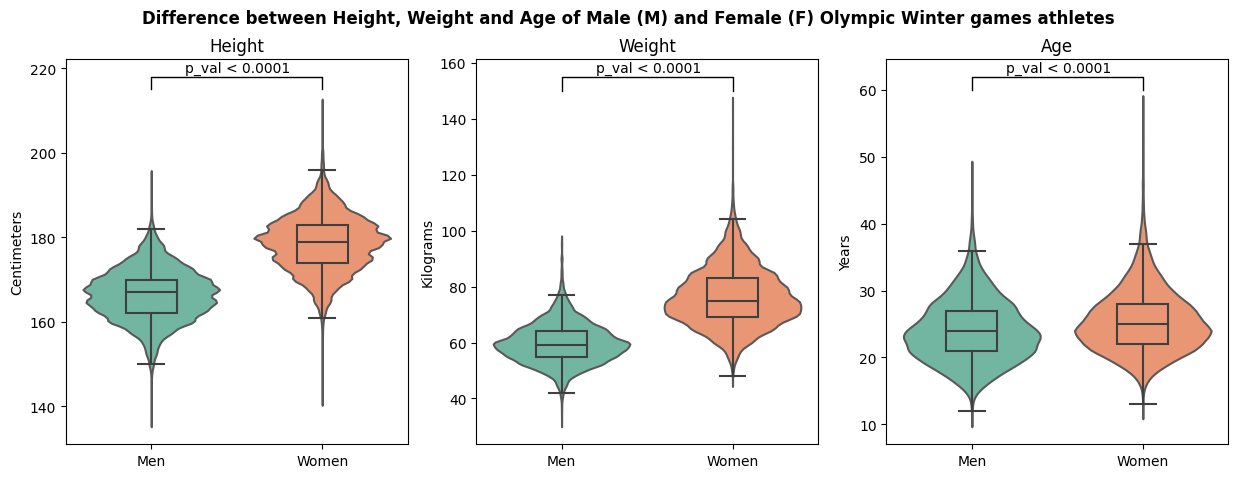

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Difference between Height, Weight and Age of Male (M) and Female (F) Olympic Winter games athletes", weight='bold')

sns.violinplot(ax=axes[0], x="Sex", y="Height", data=data_for_plot, hue="Sex", dodge=False,
                    palette="Set2",
                    scale="width", inner=None)

sns.boxplot(ax=axes[0], x="Sex", y="Height", data=data_for_plot, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'})

sns.violinplot(ax=axes[1], x="Sex", y="Weight", data=data_for_plot, hue="Sex", dodge=False,
                    palette="Set2",
                    scale="width", inner=None)

sns.boxplot(ax=axes[1], x="Sex", y="Weight", data=data_for_plot, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'})

sns.violinplot(ax=axes[2], x="Sex", y="Age", data=data_for_plot, hue="Sex", dodge=False,
                    palette="Set2",
                    scale="width", inner=None)

sns.boxplot(ax=axes[2], x="Sex", y="Age", data=data_for_plot, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'})



axes[0].set_title("Height")
axes[1].set_title("Weight")
axes[2].set_title("Age")
axes[0].set_ylabel("Centimeters")
axes[1].set_ylabel("Kilograms")
axes[2].set_ylabel("Years")
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[0].legend([], [], frameon=False)
axes[1].legend([], [], frameon=False)
axes[2].legend([], [], frameon=False)
axes[0].set_xticklabels(['Men', 'Women'])
axes[1].set_xticklabels(['Men', 'Women'])
axes[2].set_xticklabels(['Men', 'Women'])

axes[0].plot(
        [1, 1, 0, 0],
        [215, 218, 218, 215], lw=1, c='k'
    )

axes[1].plot(
        [1, 1, 0, 0],
        [150, 155, 155, 150], lw=1, c='k'
    )

axes[2].plot(
        [1, 1, 0, 0],
        [60, 62, 62, 60], lw=1, c='k'
    )
axes[0].text(
        x=0.2,
        y=219,
        s="p_val < 0.0001",
    )

axes[1].text(
        x=0.2,
        y=156.5,
        s="p_val < 0.0001",
    )

axes[2].text(
        x=0.2,
        y=62.70,
        s="p_val < 0.0001",
    )
;

Task 15. Are Team and Medal related? First, a little data preprocessing.

In [205]:
medals = pd.crosstab(olympic_data.Team, olympic_data.Medal, margins=True)
all_med = medals.query('Team != "All"').sort_values(by='All', ascending=False) # all teams with medal count
most_med = all_med.head(40) # top-40 countries according to medal amount
most_med = most_med.query('Team != "All"') # top-40 teams with medal count

It seems like some teams tend to have pslightly positive correlation with medal count. Let's see all teams and top-40.

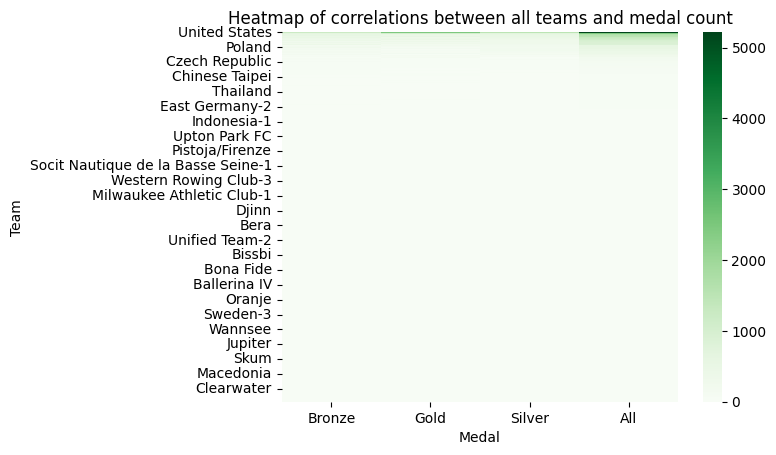

In [206]:
ax = sns.heatmap(all_med, cmap="Greens")
ax.set_title('Heatmap of correlations between all teams and medal count');

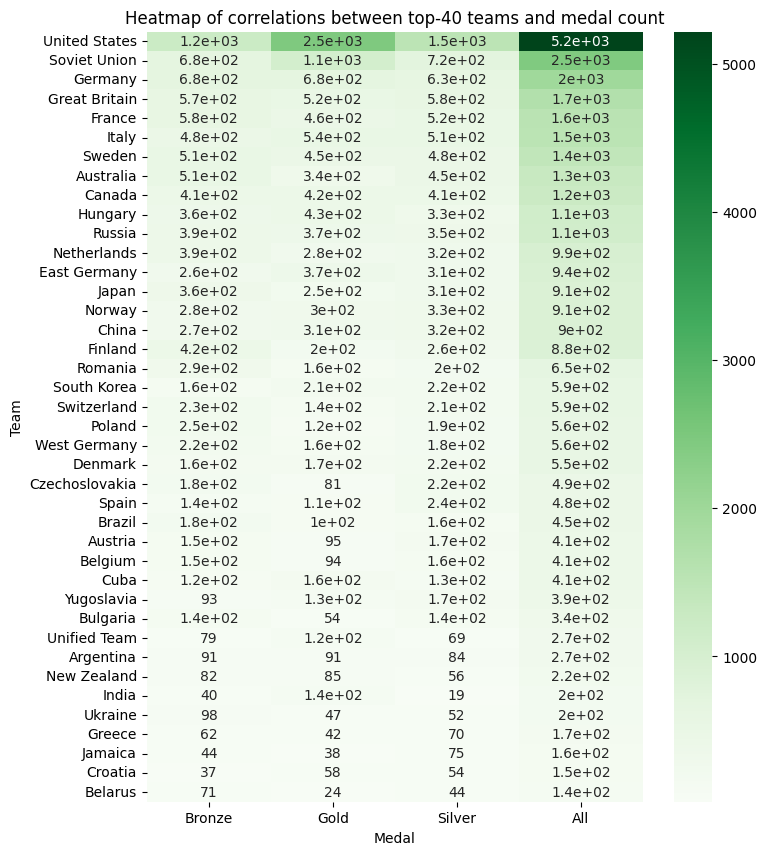

In [207]:
plt.figure(figsize = (8, 10))
ax = sns.heatmap(most_med, annot=True, cmap="Greens")
ax.set_title('Heatmap of correlations between top-40 teams and medal count');

Now we will test it with Pearson chi-square criterion.

In [208]:
all_chi = stats.chi2_contingency(all_med)
print(f'Pearson Chi-square test between all teams and medal count demonstrates chi-value {all_chi[0].round(2)}, p-value {all_chi[1].round(2)}, df = {all_chi[2]}.')

Pearson Chi-square test between all teams and medal count demonstrates chi-value 5270.62, p-value 0.0, df = 1491.


In [209]:
most_chi = stats.chi2_contingency(most_med)
print(f'Pearson Chi-square test between top-40 teams and medal count demonstrates chi-value {most_chi[0].round(2)}, p-value {most_chi[1].round(2)}, df = {most_chi[2]}.')

Pearson Chi-square test between top-40 teams and medal count demonstrates chi-value 1443.67, p-value 0.0, df = 117.


We can conclude that team and medal are related, and some teams have more probability of gaining a medal.

Task 16. Some random hypotheses.

1. Do Weight and Height of athletes playing big tennis and table tennis differ? First, let's create a smallish dataset with only these spotrs.

In [210]:
tennis_df = olympic_data.query('Sport == "Tennis" or Sport == "Table Tennis"').dropna()
tennis_df.head()

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Age_category,Height_z_scores,Height_min_max_scaled
2036,2040,69319,Li Ching,M,29.0,166.0,55.0,Hong Kong-2,HKG,2004 Summer,2004.0,Summer,Athina,Table Tennis,Table Tennis Men's Doubles,Silver,20-29,-0.887818,0.393939
2194,2198,69386,Li Huifen,F,24.0,168.0,52.0,China,CHN,1988 Summer,1988.0,Summer,Seoul,Table Tennis,Table Tennis Women's Singles,Silver,20-29,-0.697680,0.414141
2205,2209,69392,Li Jia Wei,F,26.0,170.0,60.0,Singapore,SGP,2008 Summer,2008.0,Summer,Beijing,Table Tennis,Table Tennis Women's Team,Silver,20-29,-0.507542,0.434343
2206,2210,69392,Li Jia Wei,F,30.0,170.0,60.0,Singapore,SGP,2012 Summer,2012.0,Summer,London,Table Tennis,Table Tennis Women's Team,Bronze,30-39,-0.507542,0.434343
2278,2282,69420,Li Ju,F,24.0,164.0,53.0,China,CHN,2000 Summer,2000.0,Summer,Sydney,Table Tennis,Table Tennis Women's Singles,Silver,20-29,-1.077956,0.373737


We can see that it is more likely that rather sex than sport is related to Height and Weight. At the same time we see that both these variables seemingly correlate. We have to check this and if they correlate, we will use Body Mass Index.

''

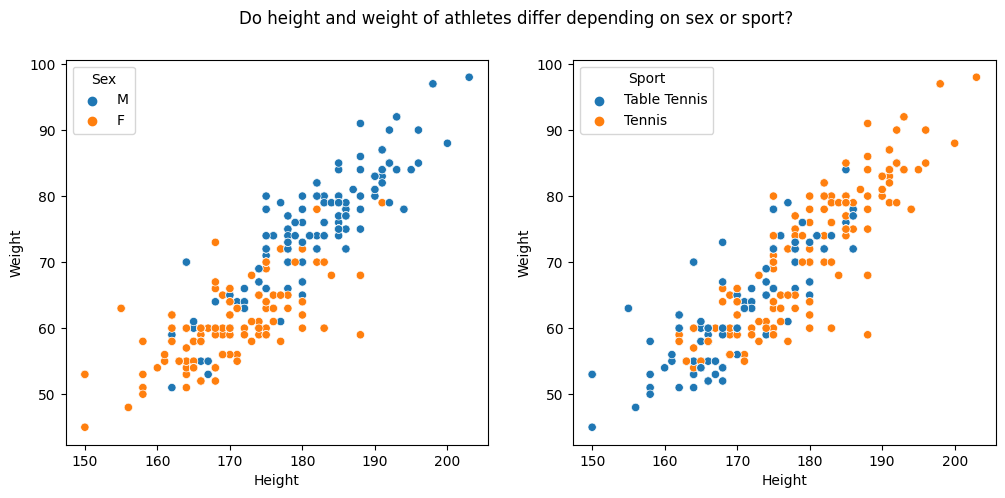

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle('Do height and weight of athletes differ depending on sex or sport?')
sns.scatterplot(ax=axes[0], data=tennis_df, x='Height', y='Weight', hue='Sex')
sns.scatterplot(ax=axes[1], data=tennis_df, x='Height', y='Weight', hue='Sport')
;

In [212]:
print(f'Normality test of Height p-value is {stats.normaltest(tennis_df.Height.dropna()).pvalue}, therefore, does not have a normal distribution')
print(f'Normality test of Weight p-value is {stats.normaltest(tennis_df.Weight.dropna()).pvalue}, therefore, has a normal distribution')

Normality test of Height p-value is 0.13549798986265785, therefore, does not have a normal distribution
Normality test of Weight p-value is 9.584649932956653e-06, therefore, has a normal distribution


In [213]:
h_w_corr = stats.spearmanr(tennis_df.Height.dropna(), tennis_df.Weight.dropna())
print(f'Spearman correlation between Height and Weight of Tennis athletes has correlation coefficient {h_w_corr[0]} and p-value {h_w_corr[1]}')

Spearman correlation between Height and Weight of Tennis athletes has correlation coefficient 0.8714412881585484 and p-value 2.3576218166278978e-105


We see that Height and Weight of Tennis athletes have a strong significant correlation. Let's use BMI instead.

In [214]:
tennis_df['BMI'] = tennis_df.Weight / (tennis_df.Height / 100) ** 2

''

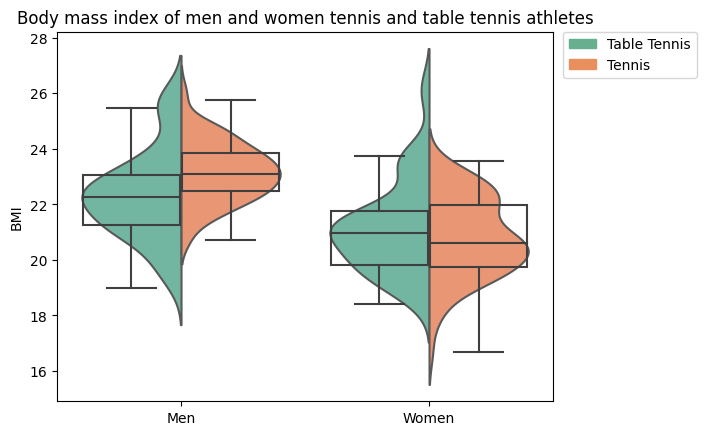

In [215]:
sns.violinplot(x="Sex", y="BMI", data=tennis_df, hue="Sport", 
                    dodge=False, split=True,
                    palette="Set2", alpha=0.05,
                    scale="width", inner=None)

sns.boxplot(x="Sex", y="BMI", data=tennis_df, hue="Sport",
                    saturation=1, showfliers=False,
                    boxprops={'zorder': 3, 'facecolor': 'none'})

pop_a = mpatches.Patch(color='#68AF8F', label='Table Tennis')
pop_b = mpatches.Patch(color='#E88F5D', label='Tennis')
plt.legend(handles=[pop_a,pop_b], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Body mass index of men and women tennis and table tennis athletes")
plt.xlabel("")
plt.xticks([0, 1], ['Men', 'Women'])
;

Interestingly, we can notice that it seems like male table tennis players have lower BMI than women and vice versa.
We could suspect that when we dropped na, maybe some age categories became differently represented. Let's check it.

In [216]:
tennis_df.groupby(['Sex', 'Sport', 'Age_category']).agg({'Age_category': 'count'}).rename(columns={'Age_category': 'Athletes_number'}).reset_index()

,Sex,Sport,Age_category,Athletes_number
0,F,Table Tennis,10-19,9
1,F,Table Tennis,20-29,65
2,F,Table Tennis,30-39,6
3,F,Tennis,10-19,8
4,F,Tennis,20-29,57
5,F,Tennis,30-39,19
6,M,Table Tennis,10-19,2
7,M,Table Tennis,20-29,69
8,M,Table Tennis,30-39,12
9,M,Tennis,20-29,70


Yeah, maybe... We see that we miss the group of male tennis players of age category 10-19, that might have impacted our violin/boxplot. And from the other side we will need here ANOVA, not pair-tests, so this I will do in my next homework ;) Stay tuned, I have a cuple ideas for tennis players.

2. Another hypotheses. Does BMI correlate with sport on athletes?

In [217]:
bmi_an = olympic_data
bmi_an['BMI'] = bmi_an.Weight / (bmi_an.Height / 100) ** 2

In [218]:
bmi_an.BMI.describe() # min == 8, max == 63, categorize with step 8

count    206819.000000
mean         22.784590
std           2.912276
min           8.360954
25%          20.957171
50%          22.530864
75%          24.212293
max          63.901580
Name: BMI, dtype: float64

In [219]:
bmi_an['BMI_category'] = bmi_an.BMI // 8

In [220]:
bmi_cross = pd.crosstab(bmi_an.Sport, bmi_an.BMI_category, margins=True)
bmi_cross = bmi_cross.query('Sport != "All"').sort_values(by='All', ascending=False)

It seems like the most correlating with BMI sports are Athletics, Swimming and Gymnastics.

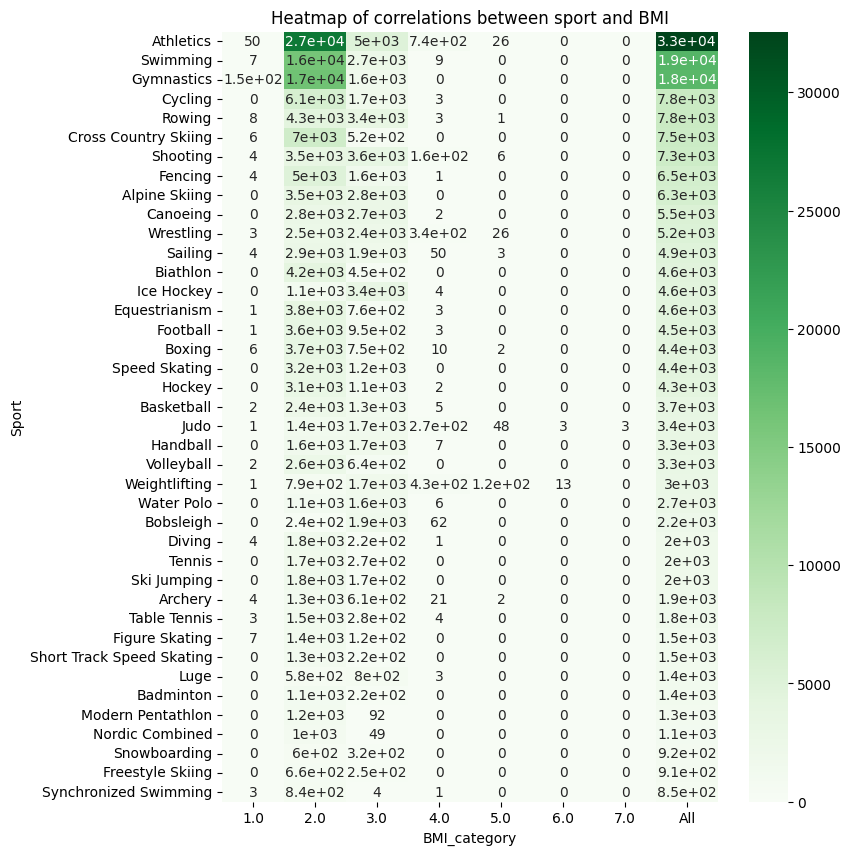

In [221]:
plt.figure(figsize = (8, 10))
ax = sns.heatmap(bmi_cross.head(40), annot=True,cmap="Greens")
ax.set_title('Heatmap of correlations between sport and BMI');

In [222]:
bmi_cor_top_40 = stats.chi2_contingency(bmi_cross.head(40))
print(f'Pearson Chi-square test between sport and athlete BMI demonstrates chi-value {most_chi[0].round(2)}, p-value {most_chi[1].round(2)}, df = {most_chi[2]}.')

Pearson Chi-square test between sport and athlete BMI demonstrates chi-value 1443.67, p-value 0.0, df = 117.


Do athletes BMI depend on age? Maybe in athletics, swimming and gymnastics all athletes are just so young?

In [223]:
bmi_top_3 = bmi_an.query('Sport == "Athletics" or Sport == "Swimming" or Sport == "Gymnastics"')

It seems like in neither of these three sports there is a correlation between age and bmi... We shall check.

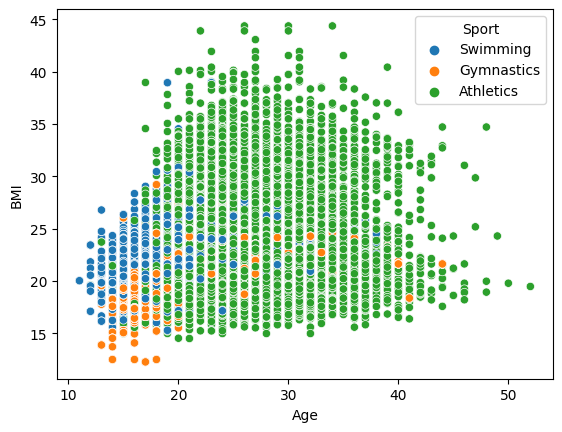

In [224]:
sns.scatterplot(data=bmi_top_3, x='Age', y='BMI', hue='Sport');

In [225]:
print(f'Normality test of Age p-value is {stats.normaltest(bmi_top_3.Age.dropna()).pvalue}, therefore, has a normal distribution')
print(f'Normality test of BMI p-value is {stats.normaltest(bmi_top_3.BMI.dropna()).pvalue}, therefore, has a normal distribution')

Normality test of Age p-value is 0.0, therefore, has a normal distribution
Normality test of BMI p-value is 0.0, therefore, has a normal distribution


In [226]:
bmi_top_3 = bmi_top_3[['Age', 'BMI', 'Sport']].dropna()

In [227]:
age_bmi_corr = stats.pearsonr(bmi_top_3.Age.dropna(), bmi_top_3.BMI.dropna())
print(f'Pearson correlation between Height and Weight of Athletics, Gymnastics and Swimming athletes has correlation coefficient {h_w_corr[0]} and p-value {h_w_corr[1]}, therefore we can assume the correlation')

Pearson correlation between Height and Weight of Athletics, Gymnastics and Swimming athletes has correlation coefficient 0.8714412881585484 and p-value 2.3576218166278978e-105, therefore we can assume the correlation


In [228]:
bmi_top_3_athl = bmi_top_3.query('Sport == "Athletics"')
print(f'Normality test of Age p-value is {stats.normaltest(bmi_top_3_athl.Age.dropna()).pvalue}, therefore, has a normal distribution')
print(f'Normality test of BMI p-value is {stats.normaltest(bmi_top_3_athl.BMI.dropna()).pvalue}, therefore, has a normal distribution')
age_bmi_corr_athl = stats.pearsonr(bmi_top_3_athl.Age.dropna(), bmi_top_3_athl.BMI.dropna())
print(f'Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient {age_bmi_corr_athl[0]} and p-value {age_bmi_corr_athl[1]}, therefore we can assume the correlation')

Normality test of Age p-value is 0.0, therefore, has a normal distribution
Normality test of BMI p-value is 0.0, therefore, has a normal distribution
Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient 0.0744120637218333 and p-value 5.573646425106527e-41, therefore we can assume the correlation


In [229]:
bmi_top_3_swim = bmi_top_3.query('Sport == "Swimming"')
print(f'Normality test of Age p-value is {stats.normaltest(bmi_top_3_swim.Age.dropna()).pvalue}, therefore, has a normal distribution')
print(f'Normality test of BMI p-value is {stats.normaltest(bmi_top_3_swim.BMI.dropna()).pvalue}, therefore, has a normal distribution')
age_bmi_corr_swim = stats.pearsonr(bmi_top_3_swim.Age.dropna(), bmi_top_3_swim.BMI.dropna())
print(f'Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient {age_bmi_corr_swim[0]} and p-value {age_bmi_corr_swim[1]}, therefore we can assume the correlation')

Normality test of Age p-value is 4.519944622216929e-223, therefore, has a normal distribution
Normality test of BMI p-value is 2.2144892871874787e-264, therefore, has a normal distribution
Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient 0.2230769607953474 and p-value 2.2152624355304922e-210, therefore we can assume the correlation


In [230]:
bmi_top_3_gymn = bmi_top_3.query('Sport == "Gymnastics"')
print(f'Normality test of Age p-value is {stats.normaltest(bmi_top_3_gymn.Age.dropna()).pvalue}, therefore, has a normal distribution')
print(f'Normality test of BMI p-value is {stats.normaltest(bmi_top_3_gymn.BMI.dropna()).pvalue}, therefore, has a normal distribution')
age_bmi_corr_gymn = stats.pearsonr(bmi_top_3_gymn.Age.dropna(), bmi_top_3_gymn.BMI.dropna())
print(f'Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient {age_bmi_corr_gymn[0]} and p-value {age_bmi_corr_gymn[1]}, therefore we can assume the correlation')

Normality test of Age p-value is 8.805017762135941e-138, therefore, has a normal distribution
Normality test of BMI p-value is 1.0242523698626496e-87, therefore, has a normal distribution
Pearson correlation between Height and Weight of Athletics athletes has correlation coefficient 0.5438471423260285 and p-value 0.0, therefore we can assume the correlation
